### NLP 

### Read Data

In [13]:
!pip install -U azureml-fsspec mltable


StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 16, Finished, Available)

In [2]:
!pip install seaborn


StatementMeta(, , -1, Finished, Available)

You should consider upgrading via the '/nfs4/pyenv-bc62b20c-0084-442a-bca9-a431e4feafbe/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install nltk

StatementMeta(, , -1, Finished, Available)

You should consider upgrading via the '/nfs4/pyenv-bc62b20c-0084-442a-bca9-a431e4feafbe/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
spark

StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 25, 6, Finished, Available)

In [5]:
!pip install plotly

StatementMeta(, , -1, Finished, Available)

You should consider upgrading via the '/nfs4/pyenv-bc62b20c-0084-442a-bca9-a431e4feafbe/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%%configure -f \
{"conf": {"spark.jars.packages": "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.2"}}

StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, -1, Finished, Available)

Unrecognized options: 

In [3]:
!pip install spark-nlp

StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 6, Finished, Available)

     |████████████████████████████████| 540 kB 9.8 MB/s eta 0:00:01


In [4]:
# load libraries
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import json
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline

StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 7, Finished, Available)

In [9]:
# Azure Machine Learning workspace details:
subscription = '58bb8a15-5d27-4d02-a5ca-772d24ae37a8'
resource_group = 'project-rg'
workspace = 'group-02-aml'
datastore_name = 'workspaceblobstore'
path_on_datastore = 'filtered-submissions-all2'

# long-form Datastore uri format:
uri = f'azureml://subscriptions/{subscription}/resourcegroups/{resource_group}/workspaces/{workspace}/datastores/{datastore_name}'
print(uri)
print(path_on_datastore)

StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 12, Finished, Available)

azureml://subscriptions/58bb8a15-5d27-4d02-a5ca-772d24ae37a8/resourcegroups/project-rg/workspaces/group-02-aml/datastores/workspaceblobstore
filtered-submissions-all2


In [14]:
from azureml.fsspec import AzureMachineLearningFileSystem

# create the filesystem
fs = AzureMachineLearningFileSystem(uri)

# append parquet files in folder to a list
dflist = []
for path in fs.glob(f'{path_on_datastore}/*.parquet'):
    with fs.open(path) as f:
        dflist.append(pd.read_parquet(f))

# concatenate data frames
reddit_df = pd.concat(dflist)

StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 17, Finished, Available)

ModuleNotFoundError: No module named 'fsspec.callbacks'

In [18]:
import os
os.getcwd()

StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 21, Finished, Available)

'/synfs/notebook/26/aml_notebook_mount'

In [33]:
# only run this when not doing spark NLP
data_path = "Users/fall-2023-reddit-project-team-02/data/csv/"
reddit_df = pd.read_csv(data_path + "reddit_df.csv")
# reddit_df = pd.read_csv("../../data/csv/reddit_df.csv")
reddit_df.head()

StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 36, Finished, Available)

In [21]:
# check for null values
cols_to_drop = []
for i in reddit_df.columns:
    print(i, '\t\t\t', reddit_df[i].isna().sum(), reddit_df[i].isna().sum()/len(reddit_df))
    if (reddit_df[i].isna().sum()/len(reddit_df)) > .90:
        cols_to_drop.append(i)
# drop null values
reddit_df = reddit_df.drop(cols_to_drop, axis = 'columns')

# Convert 'created_utc' to datetime
reddit_df['created_utc'] = pd.to_datetime(reddit_df['created_utc'])

# Extract year from 'created_utc'
reddit_df['year'] = reddit_df['created_utc'].dt.year
reddit_df['year'] = reddit_df['year'].astype('str')

# Extract month from 'created_utc'
reddit_df['month'] = reddit_df['created_utc'].dt.month

# feature engineering
# Create labels engagement_label
reddit_df['engagement_label'] = np.where((reddit_df['num_comments'] >= 0) & (reddit_df['num_comments'] < 20), 'low',
                                np.where((reddit_df['num_comments'] >= 20) & (reddit_df['num_comments'] < 100), 'medium', 'high'))

# Create labels score_label
reddit_df['score_label'] = np.where((reddit_df['score'] >= 0) & (reddit_df['score'] < 84), 'low',
                                np.where((reddit_df['score'] >= 84) & (reddit_df['score'] < 200), 'medium', 'high'))
                        
# Create labels num_words
reddit_df['num_words'] = reddit_df.fillna('').apply(lambda row: len(row['selftext'].split() + row['title'].split()), axis = 'columns')


StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 24, Finished, Available)

archived 			 0 0.0
author 			 0 0.0
contest_mode 			 0 0.0
created_utc 			 0 0.0
domain 			 13080 0.060167253926051316
edited 			 0 0.0
gilded 			 0 0.0
hidden 			 0 0.0
hide_score 			 0 0.0
id 			 0 0.0
is_crosspostable 			 0 0.0
is_reddit_media_domain 			 0 0.0
is_self 			 0 0.0
is_video 			 0 0.0
link_flair_css_class 			 164520 0.756782615895563
link_flair_text 			 123324 0.5672833656862655
locked 			 0 0.0
media_embed 			 0 0.0
num_comments 			 0 0.0
num_crossposts 			 0 0.0
over_18 			 0 0.0
parent_whitelist_status 			 0 0.0
permalink 			 0 0.0
pinned 			 0 0.0
post_hint 			 171158 0.7873170372687379
preview 			 171158 0.7873170372687379
retrieved_on 			 47946 0.2205488651940716
score 			 0 0.0
secure_media_embed 			 0 0.0
selftext 			 82012 0.37725052209352605
spoiler 			 0 0.0
stickied 			 0 0.0
subreddit 			 0 0.0
subreddit_id 			 0 0.0
thumbnail 			 0 0.0
thumbnail_height 			 118220 0.5438052568148155
thumbnail_width 			 118220 0.5438052568148155
title 			 0 0.0
url 			 13080 

In [22]:
# check the first few row of reddit_df
print(reddit_df.head(2))

StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 25, Finished, Available)

   archived     author  contest_mode         created_utc        domain  \
0     False  [deleted]         False 2023-02-22 21:23:45           NaN   
1     False  thewheisk         False 2023-02-22 21:25:33  self.Seattle   

          edited  gilded  hidden  hide_score       id  ...  thumbnail_height  \
0  1.677101214E9       0   False       False  119dv0z  ...               NaN   
1          false       0   False       False  119dxqq  ...               NaN   

   thumbnail_width                                              title  \
0              NaN        Should I move to D.C. or commute from NoVa?   
1              NaN  ChatGPT - what should happen to a sitting memb...   

                                                 url whitelist_status  year  \
0                                                NaN          all_ads  2023   
1  https://www.reddit.com/r/Seattle/comments/119d...          all_ads  2023   

   month engagement_label  score_label  num_words  
0      2              low 

### Identify important keywords 

Use regex searches to create at least two dummy variables to identify comments on particular topics

|dummy | regex|
|-----------|-----------|
|airbnb|**(?i)airbnb**|
|rent|**(?i)rent\|(?i)rental\|(?i)renting**|
|gentrification|**(?i)gentrification\|(?i)gentrify\|(?i)gentrified**|
|public transit|**(?i)public\s+transit\|(?i)bus\|(?i)subway\|(?i)metro\|(?i)tram**|
|tourists|**(?i)tourist\|(?i)tourism**|



In [23]:
from pyspark.sql import SparkSession

# Convert pandas DataFrame to PySpark DataFrame
reddit_df_spark = spark.createDataFrame(reddit_df)

StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 26, Finished, Available)

In [24]:
reddit_df_spark.printSchema()

StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 27, Finished, Available)

root
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- contest_mode: boolean (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- domain: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- hidden: boolean (nullable = true)
 |-- hide_score: boolean (nullable = true)
 |-- id: string (nullable = true)
 |-- is_crosspostable: boolean (nullable = true)
 |-- is_reddit_media_domain: boolean (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- is_video: boolean (nullable = true)
 |-- link_flair_css_class: string (nullable = true)
 |-- link_flair_text: string (nullable = true)
 |-- locked: boolean (nullable = true)
 |-- media_embed: string (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- num_crossposts: long (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- parent_whitelist_status: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- pinn

In [25]:
from pyspark.sql.functions import col,when,count

# For "airbnb" dummy variable
reddit_df_spark = reddit_df_spark.withColumn("airbnb", col("selftext").rlike(r"(?i)airbnb"))
# For "rent" dummy variable
reddit_df_spark = reddit_df_spark.withColumn("rent", col("selftext").rlike(r"(?i)rent|rental|renting"))
# For "gentrification" dummy variable
reddit_df_spark = reddit_df_spark.withColumn("gentrification", col("selftext").rlike(r"(?i)gentrification|gentrify|gentrifier|gentrifiers|gentrified"))
# For "public_transit" dummy variable
reddit_df_spark = reddit_df_spark.withColumn("public_transit", col("selftext").rlike(r"(?i)public\s+transit|bus|subway|metro|tram"))
# For "tourists" dummy variable
reddit_df_spark = reddit_df_spark.withColumn("tourists", col("selftext").rlike(r"(?i)tourist|tourism"))


StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 28, Finished, Available)

In [26]:
from pyspark.sql import functions as F

# Group by the dummy variables and count each group
result_a = reddit_df_spark.groupBy('airbnb').agg(F.count('*').alias('Count'))

StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 29, Finished, Available)

In [27]:
result_a

StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 30, Finished, Available)

DataFrame[airbnb: boolean, Count: bigint]

###  Define Spark NLP pipleline

In [28]:
# Step 1: Transforms raw title into 'document' annotation
documentAssembler = DocumentAssembler()\
    .setInputCol("selftext")\
    .setOutputCol("document")

# Step 2: Annotate sentences in the document
sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Step 3: Tokenize the sentences into tokens
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Step 4: Normalize the tokens
normalizer = Normalizer()\
    .setInputCols(["token"])\
    .setOutputCol("normalized")\
    .setLowercase(True)\
    .setCleanupPatterns(["[^\w\d\s]"])  # Removes any non-word, non-digit, non-whitespace characters

# Step 5: Clean tokens using the StopWordsCleaner
stop_words_cleaner = StopWordsCleaner().pretrained("stopwords_iso", "en")\
    .setInputCols(["normalized"])\
    .setOutputCol("cleanTokens")\
    .setCaseSensitive(False)

# Step 6: Load a pretrained Universal Sentence Encoder model
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
    .setInputCols(["document"])\
    .setOutputCol("sentence_embeddings")

# Step 7: Load a pretrained SentimentDL model for sentiment analysis
sentimentdl = SentimentDLModel.pretrained(lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

# Construct the ML pipeline
nlpPipeline = Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        normalizer,
        stop_words_cleaner,
        use,
        sentimentdl
    ])


StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 31, Finished, Available)

stopwords_iso download started this may take some time.
Approximate size to download 2.1 KB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_imdb download started this may take some time.
Approximate size to download 12 MB
[OK!]


### Run the pipeline

In [29]:
# with a column 'text' containing the text to analyze
model = nlpPipeline.fit(reddit_df_spark)
result = model.transform(reddit_df_spark)

StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 32, Finished, Available)

### Visualize results

In [30]:
# print schema
result.printSchema()
result.select("sentiment").show(3, truncate=False)

StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 33, Finished, Available)

root
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- contest_mode: boolean (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- domain: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- hidden: boolean (nullable = true)
 |-- hide_score: boolean (nullable = true)
 |-- id: string (nullable = true)
 |-- is_crosspostable: boolean (nullable = true)
 |-- is_reddit_media_domain: boolean (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- is_video: boolean (nullable = true)
 |-- link_flair_css_class: string (nullable = true)
 |-- link_flair_text: string (nullable = true)
 |-- locked: boolean (nullable = true)
 |-- media_embed: string (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- num_crossposts: long (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- parent_whitelist_status: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- pinn

In [31]:
result = result.withColumn("sentiment_act", col("sentiment").getField('result'))
result = result.drop("sentiment")
result = result.withColumnRenamed("sentiment_act", "sentiment")
result.show(2)

StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 34, Finished, Available)

+--------+---------+------------+-------------------+------------+-------------+------+------+----------+-------+----------------+----------------------+-------+--------+--------------------+---------------+------+--------------------+------------+--------------+-------+-----------------------+--------------------+------+---------+-------+-------------------+-----+--------------------+---------+-------+--------+------------+------------+---------+----------------+---------------+--------------------+--------------------+----------------+----+-----+----------------+-----------+---------+------+-----+--------------+--------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+
|archived|   author|contest_mode|        created_utc|      domain|       edited|gilded|hidden|hide_score|     id|is_crosspostable|is_reddit_media_domain|is_self|is_video|link_flair_css_class|link_flair_text|locked|    

In [51]:
result.printSchema()

StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 54, Finished, Available)

root
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- contest_mode: boolean (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- domain: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- hidden: boolean (nullable = true)
 |-- hide_score: boolean (nullable = true)
 |-- id: string (nullable = true)
 |-- is_crosspostable: boolean (nullable = true)
 |-- is_reddit_media_domain: boolean (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- is_video: boolean (nullable = true)
 |-- link_flair_css_class: string (nullable = true)
 |-- link_flair_text: string (nullable = true)
 |-- locked: boolean (nullable = true)
 |-- media_embed: string (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- num_crossposts: long (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- parent_whitelist_status: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- pinn

In [52]:
reddit_df1 = result.toPandas()

StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 55, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: ArrayType(StructType(List(StructField(annotatorType,StringType,true),StructField(begin,IntegerType,false),StructField(end,IntegerType,false),StructField(result,StringType,true),StructField(metadata,MapType(StringType,StringType,true),true),StructField(embeddings,ArrayType(FloatType,false),true))),true)
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.


In [56]:
result.write.parquet(data_path + "nlp_reddit.parquet")
reddit_df1.to_csv(data_path + "nlp_reddit_df.csv", index=False)

StatementMeta(5a58fef9-6d5a-48be-a208-b669ac871209, 26, 59, Finished, Available)

# Combine NLP Results w/ External Data

In [159]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import json
import seaborn as sns
import os

In [160]:
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/clc317-final-project/code/Users/fall-2023-reddit-project-team-02/code/wip_scripts'

In [161]:
# data_path = "Users/fall-2023-reddit-project-team-02/data/csv/"
# img_path = "Users/fall-2023-reddit-project-team-02/data/plots/"
data_path = "../../data/csv/"
img_path = "../../data/plots/"

In [162]:
reddit_df1 = pd.read_csv(data_path + "nlp_reddit_df.csv")

In [163]:
# rent as percentage
rent_perc_df = pd.read_csv(data_path + 'rent_as_percent_of_income.csv')
rent_perc_df.loc[:, 'Year'] = pd.to_datetime(rent_perc_df.loc[:, 'Year'])
rent_perc_df.loc[:, 'join_key'] = pd.to_datetime(rent_perc_df.loc[:, 'Year'])

rent_dollars_df = pd.read_csv(data_path + 'rent_in_dollars.csv')
rent_dollars_df.loc[:, 'Year'] = pd.to_datetime(rent_dollars_df.loc[:, 'Year'])

rent_df = rent_dollars_df.merge(rent_perc_df, on=['Year', 'Geographic Area Name'], how = 'outer')
rent_df.loc[:, 'County'] = rent_df.loc[:, 'County_x'].fillna(rent_df.loc[:, 'County_y'])

In [164]:
rent_df.loc[:,'year_num'] = rent_df.loc[:, 'Year'].apply(lambda x: str(x)[:4])
rent_df.head()

,Unnamed: 0_x,Geography_x,Geographic Area Name,Rent in USD,Year,County_x,Unnamed: 0_y,Geography_y,Rent as Percent of Income,County_y,join_key,County,year_num
0,1.0,1400000US11001000100,"Census Tract 1, District of Columbia, District...",1485.0,2010-01-01,District of Columbia,1.0,1400000US11001000100,28.5,District of Columbia,2010-01-01,District of Columbia,2010
1,4.0,1400000US11001000300,"Census Tract 3, District of Columbia, District...",1767.0,2010-01-01,District of Columbia,4.0,1400000US11001000300,32.3,District of Columbia,2010-01-01,District of Columbia,2010
2,5.0,1400000US11001000400,"Census Tract 4, District of Columbia, District...",1528.0,2010-01-01,District of Columbia,5.0,1400000US11001000400,29.9,District of Columbia,2010-01-01,District of Columbia,2010
3,6.0,1400000US11001000501,"Census Tract 5.01, District of Columbia, Distr...",1648.0,2010-01-01,District of Columbia,6.0,1400000US11001000501,24.4,District of Columbia,2010-01-01,District of Columbia,2010
4,7.0,1400000US11001000502,"Census Tract 5.02, District of Columbia, Distr...",1319.0,2010-01-01,District of Columbia,7.0,1400000US11001000502,27.1,District of Columbia,2010-01-01,District of Columbia,2010


In [165]:
rent_df_agg = rent_df.groupby(['Year', 'County', 'year_num'])[['Rent in USD', 'Rent as Percent of Income']].median().reset_index()

city_mappings = {'District of Columbia': 'washingtondc',
                    'Fulton County': 'Atlanta',
                    'New York County': 'nyc',
                    'King County': 'Seattle'}
rent_df_agg.loc[:, 'city'] = rent_df_agg['County'].map(city_mappings)
rent_df_agg.loc[:, 'year_city'] = rent_df_agg.loc[:, 'city']+rent_df_agg.loc[:, 'year_num']
rent_df_agg.head()

,Year,County,year_num,Rent in USD,Rent as Percent of Income,city,year_city
0,2010-01-01,District of Columbia,2010,951.0,29.50,washingtondc,washingtondc2010
1,2010-01-01,Fulton County,2010,937.0,30.70,Atlanta,Atlanta2010
2,2010-01-01,King County,2010,1054.0,28.40,Seattle,Seattle2010
3,2010-01-01,New York County,2010,1078.0,27.65,nyc,nyc2010
4,2011-01-01,District of Columbia,2011,1040.0,29.35,washingtondc,washingtondc2011


In [166]:
rent_df_agg[rent_df_agg.year_num == '2022']
rent_df_agg.year_num.unique()

array(['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020', '2021'], dtype=object)

In [167]:
reddit_df1.year.unique()

array([2023, 2021, 2022])

In [168]:
reddit_df1.loc[:, 'year_city'] = reddit_df1.loc[:, 'subreddit'] + reddit_df1.loc[:, 'year'].astype(str)
reddit_df1.loc[:, 'year_city']

0         washingtondc2023
1              Seattle2023
2              Atlanta2023
3              Seattle2023
4              Seattle2023
                ...       
217389         Atlanta2022
217390         Atlanta2021
217391         Seattle2021
217392         Seattle2022
217393         Seattle2022
Name: year_city, Length: 217394, dtype: object

In [169]:
# add to sentiment dataset
df_all = reddit_df1.merge(rent_df_agg, on = 'year_city', how = 'left')
# df_all.loc[:, 'sentiment'] = df_all.loc[:, 'sentiment'].apply(lambda x: x[0] if x else '')
df_all.loc[:, 'sentiment'] = df_all.loc[:, 'sentiment'].str.replace("\[|\]|\'", '', regex = True)
df_all.head()

,archived,author,contest_mode,created_utc,domain,edited,gilded,hidden,hide_score,id,...,cleanTokens,sentence_embeddings,sentiment,year_city,Year,County,year_num,Rent in USD,Rent as Percent of Income,city
0,False,[deleted],False,2023-02-22 21:23:45,NaN,1.677101214E9,0,False,False,119dv0z,...,"[Row(annotatorType='token', begin=0, end=6, re...","[Row(annotatorType='sentence_embeddings', begi...",neg,washingtondc2023,NaT,NaN,NaN,NaN,NaN,NaN
1,False,thewheisk,False,2023-02-22 21:25:33,self.Seattle,false,0,False,False,119dxqq,...,"[Row(annotatorType='token', begin=0, end=6, re...","[Row(annotatorType='sentence_embeddings', begi...",pos,Seattle2023,NaT,NaN,NaN,NaN,NaN,NaN
2,False,Adventurous_Emu_3359,False,2023-02-22 21:25:48,self.Atlanta,false,0,False,False,119dy30,...,"[Row(annotatorType='token', begin=7, end=12, r...","[Row(annotatorType='sentence_embeddings', begi...",neg,Atlanta2023,NaT,NaN,NaN,NaN,NaN,NaN
3,False,[deleted],False,2023-02-21 05:57:38,NaN,false,0,False,False,117w0rx,...,"[Row(annotatorType='token', begin=0, end=6, re...","[Row(annotatorType='sentence_embeddings', begi...",neg,Seattle2023,NaT,NaN,NaN,NaN,NaN,NaN
4,False,hammer838,False,2023-02-21 05:59:13,self.Seattle,false,0,False,False,117w1qz,...,"[Row(annotatorType='token', begin=5, end=8, re...","[Row(annotatorType='sentence_embeddings', begi...",pos,Seattle2023,NaT,NaN,NaN,NaN,NaN,NaN


# Visualize Sentiment

In [170]:
df_all.columns

Index(['archived', 'author', 'contest_mode', 'created_utc', 'domain', 'edited',
       'gilded', 'hidden', 'hide_score', 'id', 'is_crosspostable',
       'is_reddit_media_domain', 'is_self', 'is_video', 'link_flair_css_class',
       'link_flair_text', 'locked', 'media_embed', 'num_comments',
       'num_crossposts', 'over_18', 'parent_whitelist_status', 'permalink',
       'pinned', 'post_hint', 'preview', 'retrieved_on', 'score',
       'secure_media_embed', 'selftext', 'spoiler', 'stickied', 'subreddit',
       'subreddit_id', 'thumbnail', 'thumbnail_height', 'thumbnail_width',
       'title', 'url', 'whitelist_status', 'year', 'month', 'engagement_label',
       'score_label', 'num_words', 'airbnb', 'rent', 'gentrification',
       'public_transit', 'tourists', 'document', 'sentence', 'token',
       'normalized', 'cleanTokens', 'sentence_embeddings', 'sentiment',
       'year_city', 'Year', 'County', 'year_num', 'Rent in USD',
       'Rent as Percent of Income', 'city'],
      dty

In [171]:
airbnb_sentiment = df_all[df_all['sentiment'] != ''].groupby(['airbnb', 'sentiment']).size().unstack()
airbnb_sentiment = airbnb_sentiment.div(airbnb_sentiment.sum(axis = 1), axis = 0) * 100
airbnb_sentiment.head()

sentiment,neg,neutral,pos
airbnb,,,
False,30.813996,0.324910,68.861094
True,26.373626,1.098901,72.527473


Text(0, 0.5, 'Percentage of Posts')

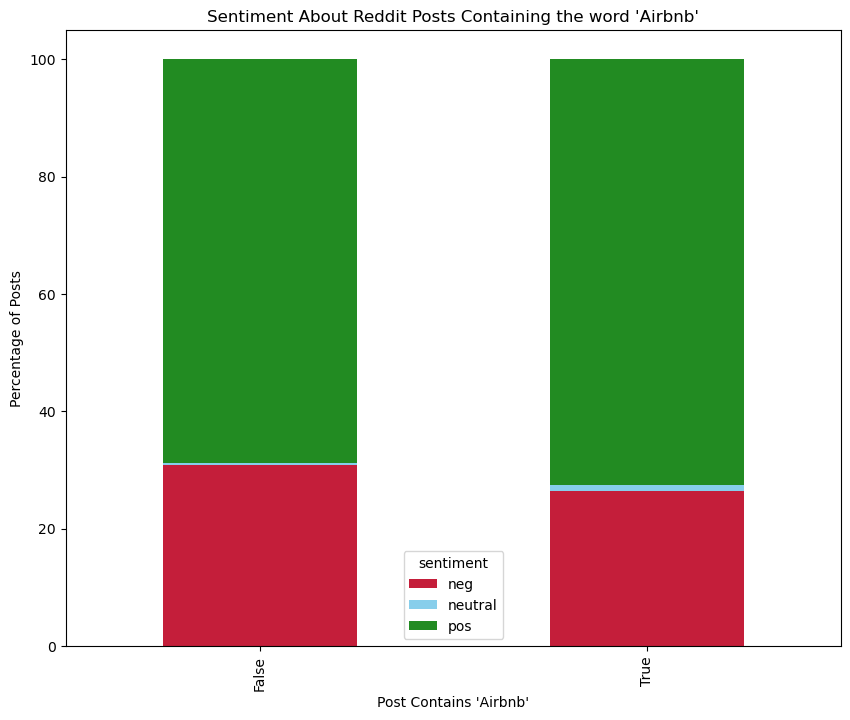

In [172]:
custom_colors = {'neg' : '#C41E3A',
                    'pos' : '#228B22',
                    'neutral' : 'skyblue'}

ax = airbnb_sentiment.plot(kind = 'bar', stacked = True, figsize = (10, 8), color =[custom_colors[col] for col in airbnb_sentiment.columns])

ax.set_title("Sentiment About Reddit Posts Containing the word 'Airbnb'")
ax.set_xlabel("Post Contains 'Airbnb'")
ax.set_ylabel("Percentage of Posts")

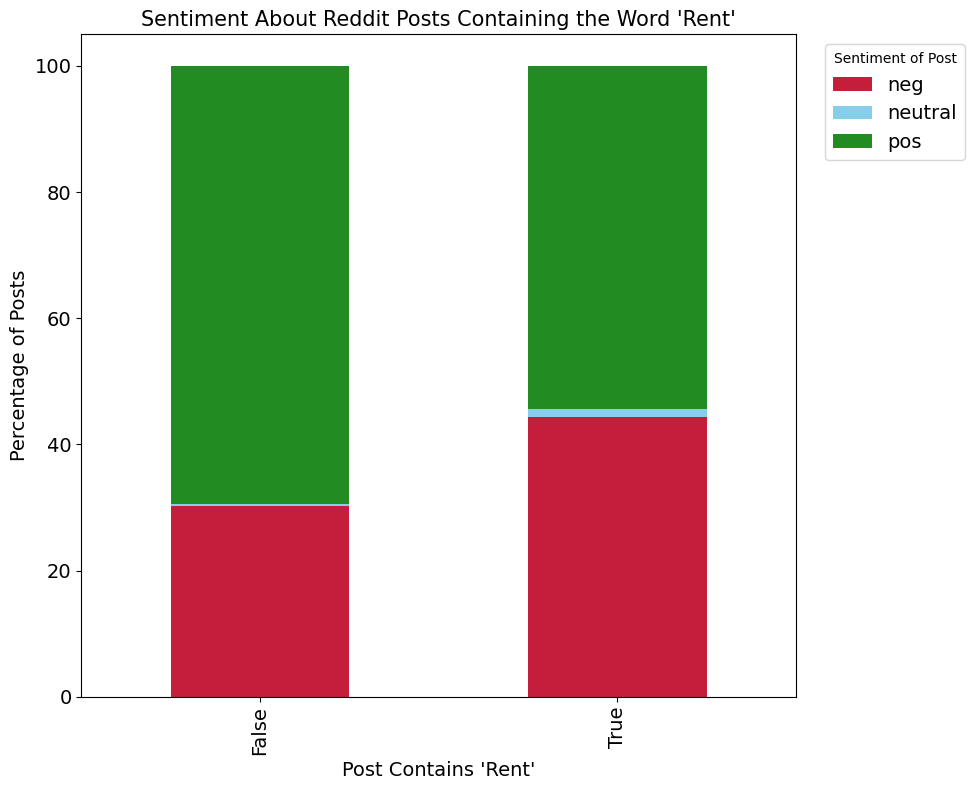

In [173]:
rent_sentiment = df_all[df_all['sentiment'] != ''].groupby(['rent', 'sentiment']).size().unstack()
rent_sentiment = rent_sentiment.div(rent_sentiment.sum(axis = 1), axis = 0) * 100
rent_sentiment.head()


ax = rent_sentiment.plot(kind = 'bar', stacked = True, figsize = (10, 8), color =[custom_colors[col] for col in airbnb_sentiment.columns])
ax.set_title("Sentiment About Reddit Posts Containing the Word 'Rent'", fontsize = 15)
ax.set_xlabel("Post Contains 'Rent'", fontsize = 14)
ax.set_ylabel("Percentage of Posts", fontsize = 14)
ax.legend(title='Sentiment of Post', fontsize=14, bbox_to_anchor=(1.25, 1), loc='upper right')
ax.tick_params(axis='both', labelsize=14)

# Adjust layout to prevent clipping of the legend
plt.tight_layout()

# Save the plot to an image file (e.g., PNG)
plt.savefig(img_path + 'rent_sentiment.png')

# Show the plot
plt.show()

# Visualize Sentiment of Rent Next to Rent Prices

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


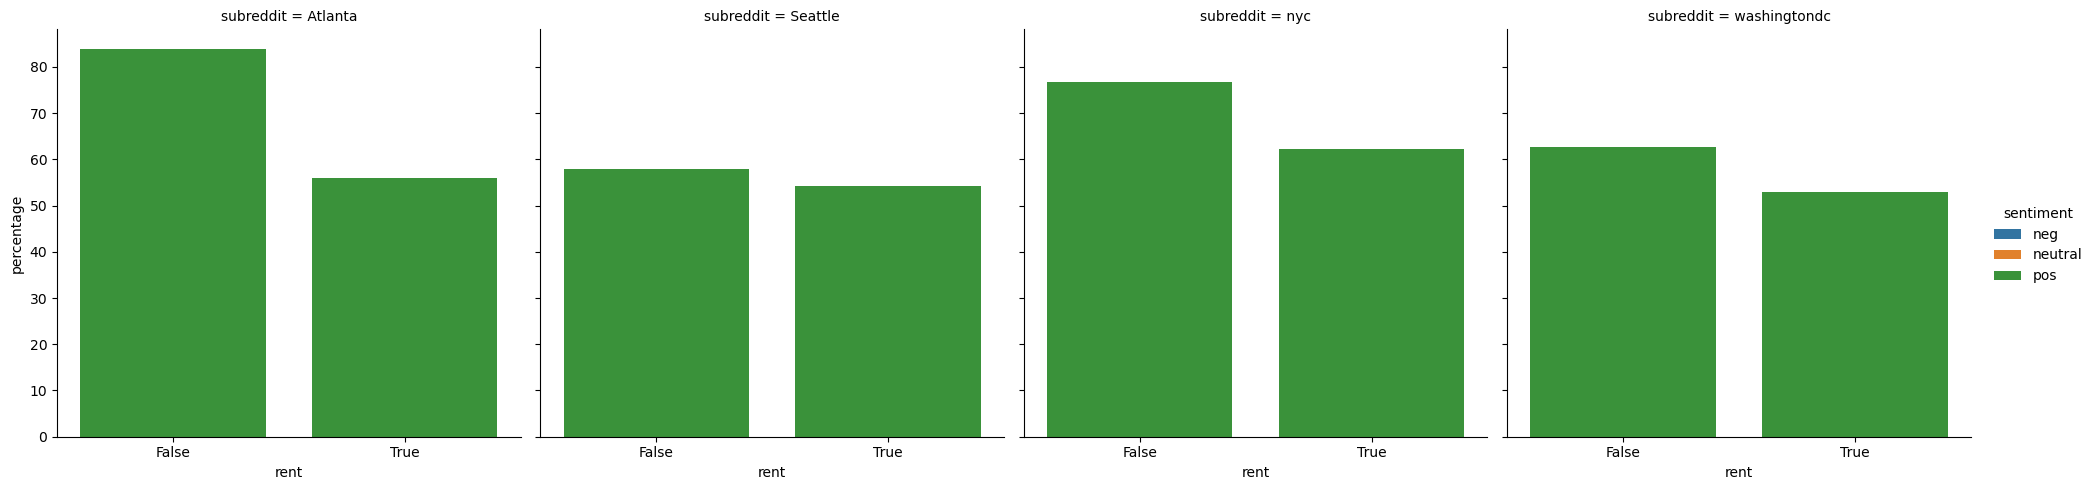

In [174]:
# city_rent_sentiment = df_all[(df_all['sentiment'] != '') & (df_all['rent'] == True)].groupby(['subreddit', 'rent', 'sentiment']).size().reset_index(name = 'count')
city_rent_sentiment = df_all[(df_all['sentiment'] != '')].groupby(['subreddit', 'rent', 'sentiment']).size().reset_index(name = 'count')
city_rent_sentiment['percentage'] = city_rent_sentiment['count'] / city_rent_sentiment.groupby(['subreddit', 'rent'])['count'].transform('sum') * 100


rent_sents = sns.FacetGrid(city_rent_sentiment,
                          col="subreddit",
                          hue = 'sentiment',
                        #   margin_titles = True,
                          height=5
                 )

rent_sents = (rent_sents.map(sns.barplot,
                                "rent",
                                "percentage",
                                linewidth=2
                        )).add_legend()

# rent_sents.set_titles(col_template = "{col_name}")  # use this argument literally
# rent_sents.set_axis_labels(y_var = '% of Reddit Posts')
        
# rent_sents.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
# rent_sents.fig.suptitle(f'Most Gentrified U.S. Cities Rent Prices in {rent_df.year_num.max()}', fontdict={'size':35})

1283


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


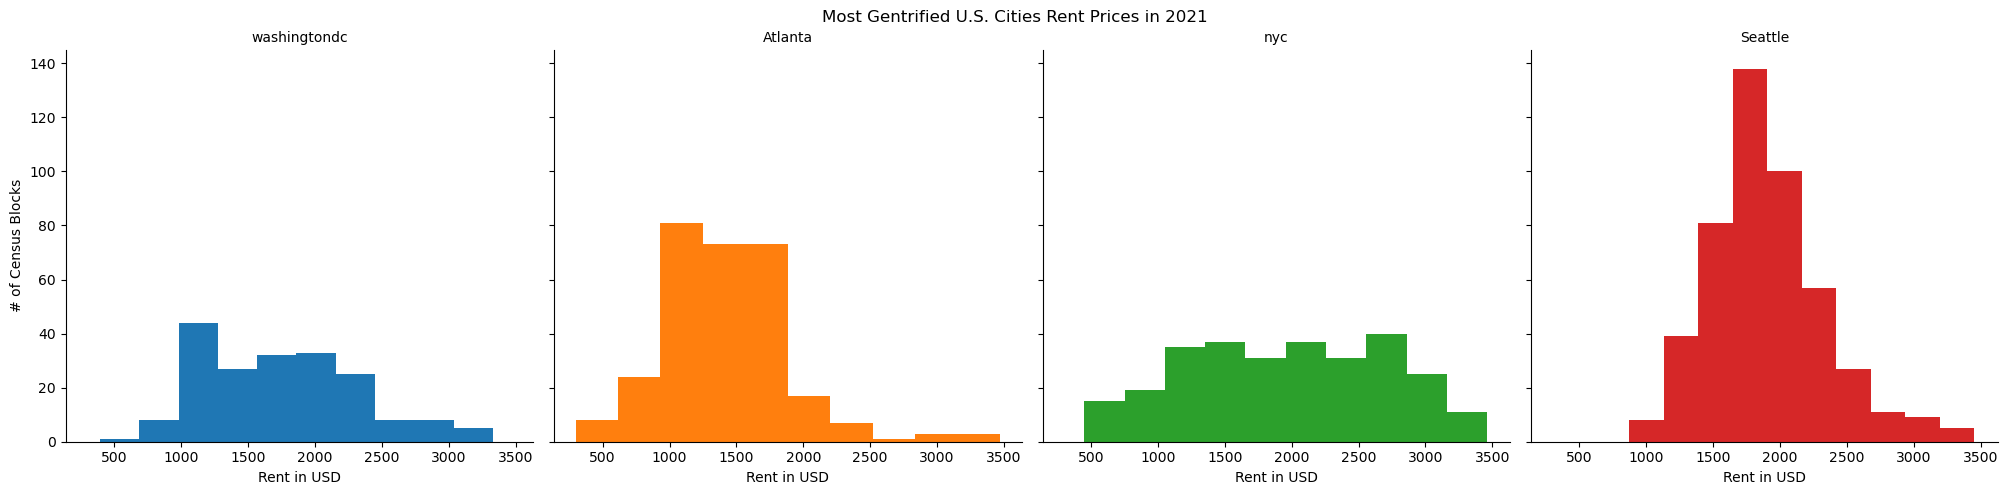

In [175]:
rent_df.loc[:, 'City'] = rent_df['County'].map(city_mappings)
last_rent_df = rent_df.loc[rent_df.year_num == rent_df.year_num.max()]
print(len(last_rent_df))

rent_hists = sns.FacetGrid(last_rent_df,
                          col="City",
                          margin_titles = True,
                          hue="City",
                          col_wrap=4,
                          height=5
                 )

rent_hists.map(plt.hist,
              "Rent in USD",
              linewidth=2
     )

rent_hists.set_titles(col_template = "{col_name}")  # use this argument literally
rent_hists.set_axis_labels(y_var = '# of Census Blocks')
        
rent_hists.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
rent_hists.fig.suptitle(f'Most Gentrified U.S. Cities Rent Prices in {rent_df.year_num.max()}', fontdict={'size':35})

plt.savefig(img_path + "rent_prices.png")

In [176]:
df_all.head()

,archived,author,contest_mode,created_utc,domain,edited,gilded,hidden,hide_score,id,...,cleanTokens,sentence_embeddings,sentiment,year_city,Year,County,year_num,Rent in USD,Rent as Percent of Income,city
0,False,[deleted],False,2023-02-22 21:23:45,NaN,1.677101214E9,0,False,False,119dv0z,...,"[Row(annotatorType='token', begin=0, end=6, re...","[Row(annotatorType='sentence_embeddings', begi...",neg,washingtondc2023,NaT,NaN,NaN,NaN,NaN,NaN
1,False,thewheisk,False,2023-02-22 21:25:33,self.Seattle,false,0,False,False,119dxqq,...,"[Row(annotatorType='token', begin=0, end=6, re...","[Row(annotatorType='sentence_embeddings', begi...",pos,Seattle2023,NaT,NaN,NaN,NaN,NaN,NaN
2,False,Adventurous_Emu_3359,False,2023-02-22 21:25:48,self.Atlanta,false,0,False,False,119dy30,...,"[Row(annotatorType='token', begin=7, end=12, r...","[Row(annotatorType='sentence_embeddings', begi...",neg,Atlanta2023,NaT,NaN,NaN,NaN,NaN,NaN
3,False,[deleted],False,2023-02-21 05:57:38,NaN,false,0,False,False,117w0rx,...,"[Row(annotatorType='token', begin=0, end=6, re...","[Row(annotatorType='sentence_embeddings', begi...",neg,Seattle2023,NaT,NaN,NaN,NaN,NaN,NaN
4,False,hammer838,False,2023-02-21 05:59:13,self.Seattle,false,0,False,False,117w1qz,...,"[Row(annotatorType='token', begin=5, end=8, re...","[Row(annotatorType='sentence_embeddings', begi...",pos,Seattle2023,NaT,NaN,NaN,NaN,NaN,NaN


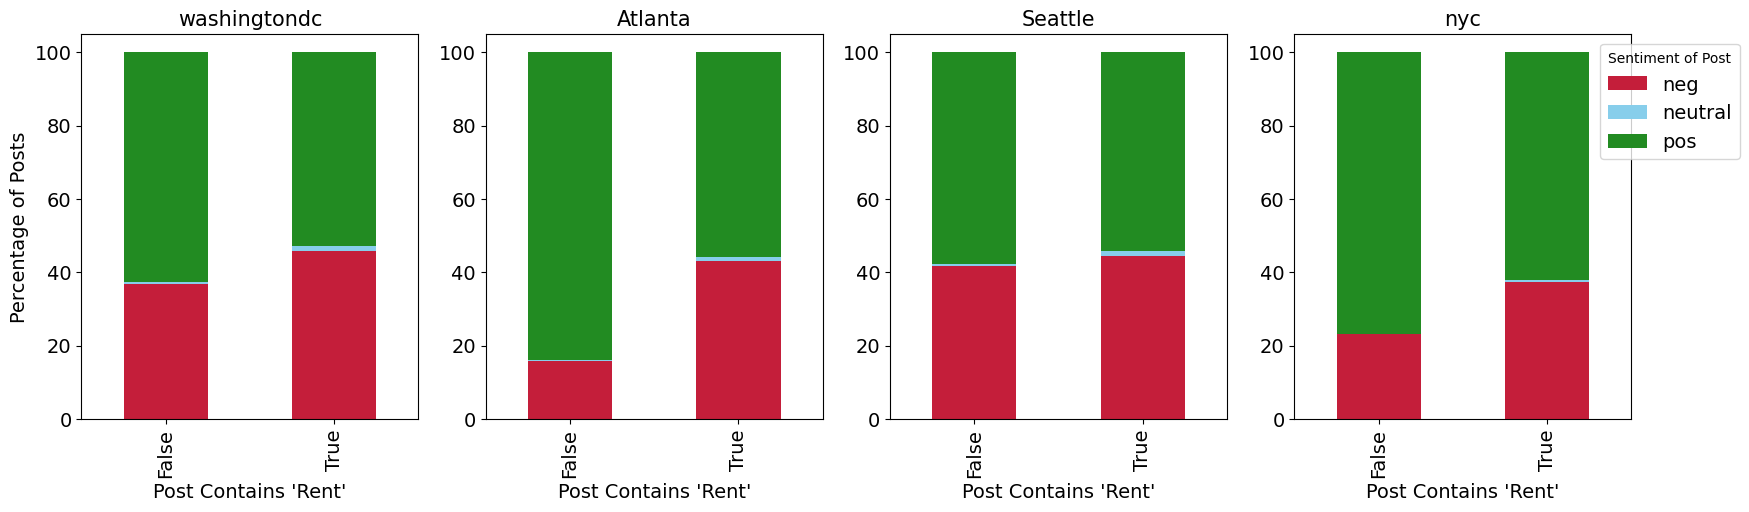

In [177]:
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 5))

city = 'washingtondc'
rent_sentiment = df_all[(df_all['sentiment'] != '') & (df_all['subreddit'] == city)].groupby(['rent', 'sentiment']).size().unstack()
rent_sentiment = rent_sentiment.div(rent_sentiment.sum(axis = 1), axis = 0) * 100
rent_sentiment.plot(kind = 'bar', stacked = True, color =[custom_colors[col] for col in airbnb_sentiment.columns], ax = ax[0], legend = False)
ax[0].set_title(f"{city}", fontsize = 15)
ax[0].set_xlabel("Post Contains 'Rent'", fontsize = 14)
ax[0].set_ylabel("Percentage of Posts", fontsize = 14)
ax[0].tick_params(axis='both', labelsize=14)


city = 'Atlanta'
rent_sentiment = df_all[(df_all['sentiment'] != '') & (df_all['subreddit'] == city)].groupby(['rent', 'sentiment']).size().unstack()
rent_sentiment = rent_sentiment.div(rent_sentiment.sum(axis = 1), axis = 0) * 100
rent_sentiment.plot(kind = 'bar', stacked = True, color =[custom_colors[col] for col in airbnb_sentiment.columns], ax = ax[1], legend = False)
ax[1].set_title(f"{city}", fontsize = 15)
ax[1].set_xlabel("Post Contains 'Rent'", fontsize = 14)
ax[1].tick_params(axis='both', labelsize=14)

city = 'Seattle'
rent_sentiment = df_all[(df_all['sentiment'] != '') & (df_all['subreddit'] == city)].groupby(['rent', 'sentiment']).size().unstack()
rent_sentiment = rent_sentiment.div(rent_sentiment.sum(axis = 1), axis = 0) * 100
rent_sentiment.plot(kind = 'bar', stacked = True, color =[custom_colors[col] for col in airbnb_sentiment.columns], ax = ax[2], legend = False)
ax[2].set_title(f"{city}", fontsize = 15)
ax[2].set_xlabel("Post Contains 'Rent'", fontsize = 14)
ax[2].tick_params(axis='both', labelsize=14)


city = 'nyc'
rent_sentiment = df_all[(df_all['sentiment'] != '') & (df_all['subreddit'] == city)].groupby(['rent', 'sentiment']).size().unstack()
rent_sentiment = rent_sentiment.div(rent_sentiment.sum(axis = 1), axis = 0) * 100
rent_sentiment.plot(kind = 'bar', stacked = True, color =[custom_colors[col] for col in airbnb_sentiment.columns], ax = ax[3], legend = False)
ax[3].set_title(f"{city}", fontsize = 15)
ax[3].set_xlabel("Post Contains 'Rent'", fontsize = 14)
ax[3].tick_params(axis='both', labelsize=14)
ax[3].legend(title='Sentiment of Post', fontsize=14, bbox_to_anchor=(1.35, 1), loc='upper right')

plt.savefig(img_path + "rent_sentment_per_city.png")

# Sentiment over time

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


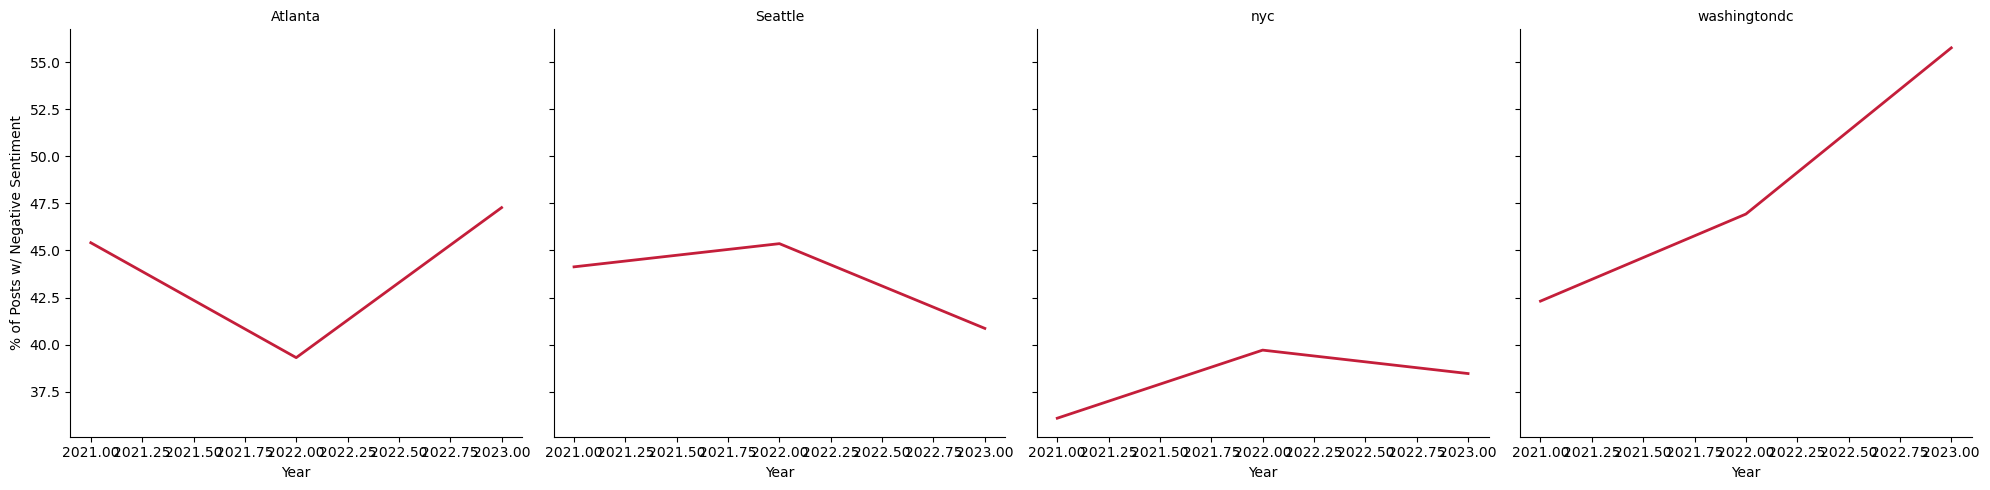

In [196]:
# sentiment over time

city_rent_sentiment = df_all[(df_all['sentiment'] != '') & (df_all['rent'] == True)].groupby(['subreddit', 'year', 'sentiment']).size().reset_index(name = 'count')
city_rent_sentiment['percentage'] = city_rent_sentiment['count'] / city_rent_sentiment.groupby(['subreddit', 'year'])['count'].transform('sum') * 100


rent_sents = sns.FacetGrid(city_rent_sentiment[city_rent_sentiment['sentiment'] == 'neg'],
                          col = 'subreddit',
                          hue = 'sentiment',
                          margin_titles = True,
                          palette = custom_colors,
                          height=5,
                          # aspect = 1.1
                 )

rent_sents = (rent_sents.map(sns.lineplot,
                                "year",
                                "percentage",
                                linewidth=2
                        ))

rent_sents.set_titles(col_template = "{col_name}")  # use this argument literally
rent_sents.set_axis_labels(x_var = 'Year', y_var = "% of Posts w/ Negative Sentiment")
# Set x-axis tick labels manually
# rent_sents.set(xticklabels=[int(i) for i in city_rent_sentiment.year.unique()])


# rent_sents.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
# rent_sents.fig.suptitle(f'Most Gentrified U.S. Cities Rent Prices in {rent_df.year_num.max()}', fontdict={'size':35})
plt.savefig(img_path + "cityrent_sentiment_overtime.png")